In [1]:
# import package

# model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch import optim
from torch.optim.lr_scheduler import StepLR

# display images
# from torchvision import utils
import matplotlib.pyplot as plt
%matplotlib inline

# utils
import numpy as np
from torchsummary import summary
import time
import copy


In [2]:
def conv_2_block(in_dim,out_dim):
    model = nn.Sequential(
        nn.Conv2d(in_dim,out_dim,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.Conv2d(out_dim,out_dim,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2)
    )
    return model

In [3]:
def conv_3_block(in_dim,out_dim):
    model = nn.Sequential(
        nn.Conv2d(in_dim,out_dim,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.Conv2d(out_dim,out_dim,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.Conv2d(out_dim,out_dim,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2)
    )
    return model

In [4]:
def conv_4_block(in_dim,out_dim):
    model = nn.Sequential(
        nn.Conv2d(in_dim,out_dim,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.Conv2d(out_dim,out_dim,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.Conv2d(out_dim,out_dim,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.Conv2d(out_dim,out_dim,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2)
    )
    return model

In [5]:
class VGG16(nn.Module):
    def __init__(self, base_dim, num_classes=10):
        super(VGG16, self).__init__()
        self.feature = nn.Sequential(
            conv_2_block(3,base_dim), #64
            conv_2_block(base_dim,2*base_dim), #128
            conv_3_block(2*base_dim,4*base_dim), #256
            conv_3_block(4*base_dim,8*base_dim), #512
            conv_3_block(8*base_dim,8*base_dim), #512
        )
        self.fc_layer = nn.Sequential(
            # CIFAR10은 크기가 32x32이므로
            nn.Linear(8*base_dim*1*1, 4096),
            # IMAGENET이면 224x224이므로
            # nn.Linear(8*base_dim*7*7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 1000),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(1000, num_classes),
        )

    def forward(self, x):
        x = self.feature(x)
        #print(x.shape)
        x = x.view(x.size(0), -1)
        #print(x.shape)
        x = self.fc_layer(x)
        return x

In [6]:
class VGG19(nn.Module):
    def __init__(self, base_dim, num_classes=10):
        super(VGG19, self).__init__()
        self.feature = nn.Sequential(
            conv_2_block(3,base_dim), #64
            conv_2_block(base_dim,2*base_dim), #128
            conv_4_block(2*base_dim,4*base_dim), #256
            conv_4_block(4*base_dim,8*base_dim), #512
            conv_4_block(8*base_dim,8*base_dim), #512
        )
        self.fc_layer = nn.Sequential(
            # CIFAR10은 크기가 32x32이므로
            nn.Linear(8*base_dim*1*1, 4096),
            # IMAGENET이면 224x224이므로
            # nn.Linear(8*base_dim*7*7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 1000),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(1000, num_classes),
        )

    def forward(self, x):
        x = self.feature(x)
        #print(x.shape)
        x = x.view(x.size(0), -1)
        #print(x.shape)
        x = self.fc_layer(x)
        return x

In [20]:
# device 설정
device = torch.device('mps:0' if torch.backends.mps.is_available() else 'cpu')

# 모델 인스턴스화
model = VGG19(base_dim=64).to(device)

# 손실 함수 및 옵티마이저 설정
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [21]:
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Transform 정의
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# CIFAR10 TRAIN 데이터 정의
cifar10_train = datasets.CIFAR10(root="Data/", train=True, transform=transform, target_transform=None, download=True)

# CIFAR10 TEST 데이터 정의
cifar10_test = datasets.CIFAR10(root="Data/", train=False, transform=transform, target_transform=None, download=True)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [22]:
train_loader = torch.utils.data.DataLoader(cifar10_train, batch_size=100,
                                           shuffle=True, num_workers=6)

In [23]:
test_loader = torch.utils.data.DataLoader(cifar10_test, batch_size=100,
                                           shuffle=False, num_workers=6)

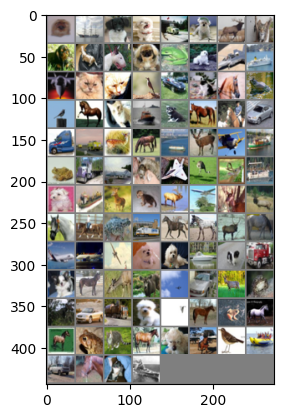

NameError: name 'batch_size' is not defined

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수
# batch_size = 10

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(train_loader)
images, labels = next(dataiter)

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))

# 정답(label) 출력
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [24]:
batch_size = 100
learning_rate = 0.001
num_epoch = 100

In [25]:
from tqdm import trange

In [26]:
import torch
print(torch.__version__)
print("MPS available:", torch.backends.mps.is_available())

2.3.0
MPS available: True


In [27]:
print (f"PyTorch version:{torch.__version__}") # 1.12.1 이상
print(f"MPS 장치를 지원하도록 build 되었는지: {torch.backends.mps.is_built()}") # True 여야 합니다.
print(f"MPS 장치가 사용 가능한지: {torch.backends.mps.is_available()}") # True 여야 합니다.
!python -c 'import platform;print(platform.platform())'

PyTorch version:2.3.0
MPS 장치를 지원하도록 build 되었는지: True
MPS 장치가 사용 가능한지: True
macOS-14.5-arm64-arm-64bit


In [28]:
loss_arr = []

for epoch in trange(num_epoch):
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    avg_loss = running_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epoch}], Loss: {avg_loss:.4f}')
    loss_arr.append(avg_loss)

  1%|▍                                        | 1/100 [01:25<2:21:35, 85.81s/it]

Epoch [1/100], Loss: 2.0852


  2%|▊                                        | 2/100 [02:52<2:21:07, 86.41s/it]

Epoch [2/100], Loss: 1.8306


  3%|█▏                                       | 3/100 [04:18<2:19:24, 86.23s/it]

Epoch [3/100], Loss: 1.6856


  4%|█▋                                       | 4/100 [05:44<2:17:50, 86.15s/it]

Epoch [4/100], Loss: 1.5084


  5%|██                                       | 5/100 [07:09<2:15:53, 85.83s/it]

Epoch [5/100], Loss: 1.3693


  6%|██▍                                      | 6/100 [08:34<2:14:02, 85.55s/it]

Epoch [6/100], Loss: 1.3087


  7%|██▊                                      | 7/100 [09:59<2:12:19, 85.37s/it]

Epoch [7/100], Loss: 1.2074


  8%|███▎                                     | 8/100 [11:24<2:10:42, 85.24s/it]

Epoch [8/100], Loss: 1.2050


  9%|███▋                                     | 9/100 [12:50<2:09:25, 85.34s/it]

Epoch [9/100], Loss: 1.1281


 10%|████                                    | 10/100 [14:15<2:07:59, 85.33s/it]

Epoch [10/100], Loss: 1.0490


 11%|████▍                                   | 11/100 [15:40<2:06:29, 85.27s/it]

Epoch [11/100], Loss: 1.0120


 12%|████▊                                   | 12/100 [17:06<2:05:08, 85.32s/it]

Epoch [12/100], Loss: 1.0066


 13%|█████▏                                  | 13/100 [18:31<2:03:41, 85.31s/it]

Epoch [13/100], Loss: 0.9630


 14%|█████▌                                  | 14/100 [19:56<2:02:13, 85.27s/it]

Epoch [14/100], Loss: 0.9706


 15%|██████                                  | 15/100 [21:22<2:00:46, 85.26s/it]

Epoch [15/100], Loss: 1.0007


 16%|██████▍                                 | 16/100 [22:47<1:59:17, 85.20s/it]

Epoch [16/100], Loss: 1.0121


 17%|██████▊                                 | 17/100 [24:12<1:57:55, 85.24s/it]

Epoch [17/100], Loss: 0.9032


 18%|███████▏                                | 18/100 [25:37<1:56:23, 85.17s/it]

Epoch [18/100], Loss: 0.8870


 19%|███████▌                                | 19/100 [27:01<1:54:35, 84.88s/it]

Epoch [19/100], Loss: 0.8133


 20%|████████                                | 20/100 [28:26<1:53:16, 84.96s/it]

Epoch [20/100], Loss: 0.7503


 21%|████████▍                               | 21/100 [29:51<1:51:56, 85.02s/it]

Epoch [21/100], Loss: 0.7128


 22%|████████▊                               | 22/100 [31:17<1:50:37, 85.09s/it]

Epoch [22/100], Loss: 0.6904


 23%|█████████▏                              | 23/100 [32:42<1:49:16, 85.15s/it]

Epoch [23/100], Loss: 0.6394


 24%|█████████▌                              | 24/100 [34:07<1:47:51, 85.15s/it]

Epoch [24/100], Loss: 0.6156


 25%|██████████                              | 25/100 [35:32<1:46:26, 85.15s/it]

Epoch [25/100], Loss: 0.5655


 26%|██████████▍                             | 26/100 [36:58<1:45:11, 85.29s/it]

Epoch [26/100], Loss: 0.5837


 27%|██████████▊                             | 27/100 [38:24<1:43:55, 85.42s/it]

Epoch [27/100], Loss: 0.4867


 28%|███████████▏                            | 28/100 [39:49<1:42:27, 85.39s/it]

Epoch [28/100], Loss: 0.6244


 29%|███████████▌                            | 29/100 [41:14<1:41:00, 85.36s/it]

Epoch [29/100], Loss: 0.7347


 30%|████████████                            | 30/100 [42:39<1:39:29, 85.29s/it]

Epoch [30/100], Loss: 0.4706


 31%|████████████▍                           | 31/100 [44:05<1:38:07, 85.33s/it]

Epoch [31/100], Loss: 0.3937


 32%|████████████▊                           | 32/100 [45:31<1:36:51, 85.47s/it]

Epoch [32/100], Loss: 0.3787


 33%|█████████████▏                          | 33/100 [46:56<1:35:24, 85.44s/it]

Epoch [33/100], Loss: 0.3413


 34%|█████████████▌                          | 34/100 [48:22<1:34:02, 85.49s/it]

Epoch [34/100], Loss: 0.3471


 35%|██████████████                          | 35/100 [49:47<1:32:38, 85.51s/it]

Epoch [35/100], Loss: 0.3142


 36%|██████████████▍                         | 36/100 [51:14<1:31:29, 85.77s/it]

Epoch [36/100], Loss: 0.2675


 37%|██████████████▊                         | 37/100 [52:39<1:29:55, 85.64s/it]

Epoch [37/100], Loss: 0.3813


 38%|███████████████▏                        | 38/100 [54:04<1:28:13, 85.38s/it]

Epoch [38/100], Loss: 0.2682


 39%|███████████████▌                        | 39/100 [55:28<1:26:38, 85.22s/it]

Epoch [39/100], Loss: 0.2316


 40%|████████████████                        | 40/100 [56:54<1:25:16, 85.28s/it]

Epoch [40/100], Loss: 0.2461


 41%|████████████████▍                       | 41/100 [58:19<1:23:46, 85.20s/it]

Epoch [41/100], Loss: 0.6069


 42%|████████████████▊                       | 42/100 [59:44<1:22:21, 85.19s/it]

Epoch [42/100], Loss: 0.3122


 43%|████████████████▎                     | 43/100 [1:01:09<1:20:59, 85.26s/it]

Epoch [43/100], Loss: 0.2216


 44%|████████████████▋                     | 44/100 [1:02:35<1:19:35, 85.27s/it]

Epoch [44/100], Loss: 0.2170


 45%|█████████████████                     | 45/100 [1:04:00<1:18:08, 85.24s/it]

Epoch [45/100], Loss: 0.2830


 46%|█████████████████▍                    | 46/100 [1:05:25<1:16:45, 85.28s/it]

Epoch [46/100], Loss: 0.4142


 47%|█████████████████▊                    | 47/100 [1:06:51<1:15:22, 85.32s/it]

Epoch [47/100], Loss: 0.3941


 48%|██████████████████▏                   | 48/100 [1:08:16<1:13:56, 85.32s/it]

Epoch [48/100], Loss: 1.9024


 49%|██████████████████▌                   | 49/100 [1:09:42<1:12:36, 85.41s/it]

Epoch [49/100], Loss: 0.8060


 50%|███████████████████                   | 50/100 [1:11:07<1:11:08, 85.37s/it]

Epoch [50/100], Loss: 0.5041


 51%|███████████████████▍                  | 51/100 [1:12:32<1:09:42, 85.36s/it]

Epoch [51/100], Loss: 0.3393


 52%|███████████████████▊                  | 52/100 [1:13:58<1:08:17, 85.37s/it]

Epoch [52/100], Loss: 0.2634


 53%|████████████████████▏                 | 53/100 [1:15:22<1:06:44, 85.19s/it]

Epoch [53/100], Loss: 0.1961


 54%|████████████████████▌                 | 54/100 [1:16:48<1:05:19, 85.21s/it]

Epoch [54/100], Loss: 0.1657


 55%|████████████████████▉                 | 55/100 [1:18:13<1:04:01, 85.36s/it]

Epoch [55/100], Loss: 0.1900


 56%|█████████████████████▎                | 56/100 [1:19:39<1:02:39, 85.44s/it]

Epoch [56/100], Loss: 0.2091


 57%|█████████████████████▋                | 57/100 [1:21:04<1:01:08, 85.31s/it]

Epoch [57/100], Loss: 0.2162


 58%|███████████████████████▏                | 58/100 [1:22:29<59:41, 85.27s/it]

Epoch [58/100], Loss: 0.1455


 59%|███████████████████████▌                | 59/100 [1:23:54<58:11, 85.17s/it]

Epoch [59/100], Loss: 0.1477


 60%|████████████████████████                | 60/100 [1:25:19<56:45, 85.15s/it]

Epoch [60/100], Loss: 0.2399


 61%|████████████████████████▍               | 61/100 [1:26:44<55:21, 85.16s/it]

Epoch [61/100], Loss: 0.1433


 62%|████████████████████████▊               | 62/100 [1:28:09<53:52, 85.07s/it]

Epoch [62/100], Loss: 0.1869


 63%|█████████████████████████▏              | 63/100 [1:29:34<52:25, 85.01s/it]

Epoch [63/100], Loss: 0.1412


 64%|█████████████████████████▌              | 64/100 [1:30:59<51:02, 85.07s/it]

Epoch [64/100], Loss: 0.1425


 65%|██████████████████████████              | 65/100 [1:32:24<49:37, 85.07s/it]

Epoch [65/100], Loss: 0.9676


 66%|██████████████████████████▍             | 66/100 [1:33:50<48:12, 85.08s/it]

Epoch [66/100], Loss: 1.1348


 67%|██████████████████████████▊             | 67/100 [1:35:15<46:49, 85.13s/it]

Epoch [67/100], Loss: 0.8616


 68%|███████████████████████████▏            | 68/100 [1:36:40<45:25, 85.16s/it]

Epoch [68/100], Loss: 0.5264


 69%|███████████████████████████▌            | 69/100 [1:38:05<44:00, 85.19s/it]

Epoch [69/100], Loss: 0.6373


 70%|████████████████████████████            | 70/100 [1:39:31<42:36, 85.20s/it]

Epoch [70/100], Loss: 0.4704


 71%|████████████████████████████▍           | 71/100 [1:40:56<41:12, 85.25s/it]

Epoch [71/100], Loss: 0.3481


 72%|████████████████████████████▊           | 72/100 [1:42:21<39:46, 85.25s/it]

Epoch [72/100], Loss: 0.3209


 73%|█████████████████████████████▏          | 73/100 [1:43:46<38:20, 85.19s/it]

Epoch [73/100], Loss: 0.1556


 74%|█████████████████████████████▌          | 74/100 [1:45:11<36:54, 85.15s/it]

Epoch [74/100], Loss: 0.1157


 75%|██████████████████████████████          | 75/100 [1:46:36<35:29, 85.17s/it]

Epoch [75/100], Loss: 0.6987


 76%|██████████████████████████████▍         | 76/100 [1:48:02<34:04, 85.20s/it]

Epoch [76/100], Loss: 0.3822


 77%|██████████████████████████████▊         | 77/100 [1:49:27<32:36, 85.08s/it]

Epoch [77/100], Loss: 0.1834


 78%|███████████████████████████████▏        | 78/100 [1:50:52<31:12, 85.13s/it]

Epoch [78/100], Loss: 0.5160


 79%|███████████████████████████████▌        | 79/100 [1:52:17<29:47, 85.13s/it]

Epoch [79/100], Loss: 0.5536


 80%|████████████████████████████████        | 80/100 [1:53:42<28:21, 85.05s/it]

Epoch [80/100], Loss: 0.2296


 81%|████████████████████████████████▍       | 81/100 [1:55:07<26:56, 85.09s/it]

Epoch [81/100], Loss: 0.1399


 82%|████████████████████████████████▊       | 82/100 [1:56:32<25:31, 85.11s/it]

Epoch [82/100], Loss: 0.2918


 83%|█████████████████████████████████▏      | 83/100 [1:57:57<24:08, 85.19s/it]

Epoch [83/100], Loss: 0.1453


 84%|█████████████████████████████████▌      | 84/100 [1:59:23<22:42, 85.14s/it]

Epoch [84/100], Loss: 0.1109


 85%|██████████████████████████████████      | 85/100 [2:00:48<21:17, 85.16s/it]

Epoch [85/100], Loss: 0.0883


 86%|██████████████████████████████████▍     | 86/100 [2:02:13<19:51, 85.09s/it]

Epoch [86/100], Loss: 0.1218


 87%|██████████████████████████████████▊     | 87/100 [2:03:38<18:25, 85.05s/it]

Epoch [87/100], Loss: 0.4433


 88%|███████████████████████████████████▏    | 88/100 [2:05:03<17:00, 85.05s/it]

Epoch [88/100], Loss: 0.1313


 89%|███████████████████████████████████▌    | 89/100 [2:06:28<15:35, 85.02s/it]

Epoch [89/100], Loss: 0.9449


 90%|████████████████████████████████████    | 90/100 [2:07:53<14:10, 85.05s/it]

Epoch [90/100], Loss: 1.5871


 91%|████████████████████████████████████▍   | 91/100 [2:09:18<12:45, 85.10s/it]

Epoch [91/100], Loss: 1.1937


 92%|████████████████████████████████████▊   | 92/100 [2:10:43<11:21, 85.15s/it]

Epoch [92/100], Loss: 0.9264


 93%|█████████████████████████████████████▏  | 93/100 [2:12:09<09:56, 85.21s/it]

Epoch [93/100], Loss: 0.6418


 94%|█████████████████████████████████████▌  | 94/100 [2:13:34<08:31, 85.17s/it]

Epoch [94/100], Loss: 0.6126


 95%|██████████████████████████████████████  | 95/100 [2:14:59<07:05, 85.17s/it]

Epoch [95/100], Loss: 0.3049


 96%|██████████████████████████████████████▍ | 96/100 [2:16:24<05:40, 85.18s/it]

Epoch [96/100], Loss: 0.1888


 97%|██████████████████████████████████████▊ | 97/100 [2:17:49<04:15, 85.22s/it]

Epoch [97/100], Loss: 0.1124


 98%|███████████████████████████████████████▏| 98/100 [2:19:15<02:50, 85.26s/it]

Epoch [98/100], Loss: 0.1961


 99%|███████████████████████████████████████▌| 99/100 [2:20:40<01:25, 85.39s/it]

Epoch [99/100], Loss: 0.2059


100%|███████████████████████████████████████| 100/100 [2:22:06<00:00, 85.26s/it]

Epoch [100/100], Loss: 0.0897


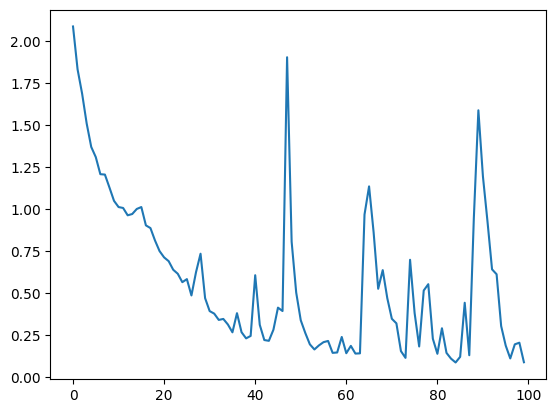

In [29]:
plt.plot(loss_arr)
plt.show()

In [30]:
# 맞은 개수, 전체 개수를 저장할 변수를 지정합니다.
correct = 0
total = 0

model.eval()

# 인퍼런스 모드를 위해 no_grad 해줍니다.
with torch.no_grad():
    # 테스트로더에서 이미지와 정답을 불러옵니다.
    for image,label in test_loader:

        # 두 데이터 모두 장치에 올립니다.
        x = image.to(device)
        y= label.to(device)

        # 모델에 데이터를 넣고 결과값을 얻습니다.
        output = model.forward(x)
        _,output_index = torch.max(output,1)


        # 전체 개수 += 라벨의 개수
        total += label.size(0)
        correct += (output_index == y).sum().float()

    # 정확도 도출
    print("Accuracy of Test Data: {}%".format(100*correct/total))

Accuracy of Test Data: 72.7699966430664%


In [17]:
print(f"Using device: {device}")
print(f"Device type set in summary: {'cpu' if device == torch.device('mps') else device.type}")


Using device: mps:0
Device type set in summary: mps


In [18]:
print(model)

VGG19(
  (feature): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): ReLU()
      (6): Conv2d(256, 256, kernel_size=(3, 3), 